# Disaster Tweet Detector (NLP): Data Wrangling and EDA

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from cleantext import clean
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from gensim.models.tfidfmodel import TfidfModel
from gensim.corpora.dictionary import Dictionary

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\justi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing Data

In [2]:
tweets = pd.read_csv('C:/Users/justi/SpringboardDS/Capstone III/data/tweets.csv')
tweets.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


## Exploring the Data

C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

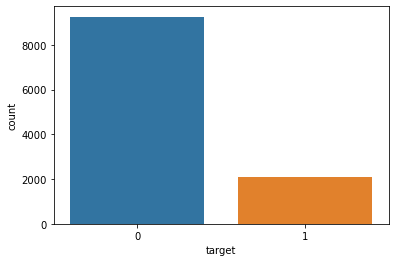

In [3]:
# Create countplot to check for balanced/unbalanced data.
sns.countplot(tweets['target'])

In [4]:
# Get frequency counts of target.
tweets['target'].value_counts()

0    9256
1    2114
Name: target, dtype: int64

In [5]:
# Get frequency percents of target.
tweets['target'].value_counts(normalize=True)

0    0.814072
1    0.185928
Name: target, dtype: float64

In [6]:
# Check variable types.
tweets.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

## Text Cleaning and Tokenization

In [7]:
# Define a function that cleans the text.
def clean_text(text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    text_no_links = re.sub(r' http\S+', '', text_no_doublespace) # remove words starting with https to get rid of links (also the space in front of the link)
    text_no_emotes = clean(text_no_links, no_emoji=True) # remove emotes along with other cleantext operations
    text_cleaned1 = re.sub(r'( \w+\.\.\.)', '', text_no_emotes) # remove "..." with any text before along with the space before (at the end of many tweets)
    text_cleaned2 = re.sub(r'( \.\.\.)', '', text_cleaned1) # remove "..." with a space before but no word
    text_cleaned3 = re.sub(r'\"', '', text_cleaned2) # Had to explicitely get rid of ",', and - for some reason...?
    text_cleaned4 = re.sub(r'\'', '', text_cleaned3)
    text_cleaned5 = re.sub(r'\-', ' ', text_cleaned4)
    return text_cleaned5

In [8]:
# Create a list of tweets to work with until later converting it back to a dataframe column.
tweets_list = tweets.text

# Iterate through all tweets. Append tweets to an empty list.
mylist=[]

for i in tweets_list[:11371]:
    cleaned_tweet = clean_text(i)
    mylist.append(cleaned_tweet)

In [9]:
# Check to see if all tweets were appended.
len(mylist)

11370

In [10]:
# Inspect first few tweets.
mylist[:20]

['communal violence in bhainsa telangana stones were pelted on muslims houses and some houses and vehicles were set',
 'telangana section has been imposed in bhainsa from january to after clash erupted between two groups on january',
 'arsonist sets cars ablaze at dealership',
 'arsonist sets cars ablaze at dealership',
 'lord jesus your love brings freedom and pardon fill me with your holy spirit and set my heart ablaze with your',
 'if this child was chinese this tweet would have gone viral social media would be ablaze snl would have made a racist',
 'several houses have been set ablaze in ngemsibaa village oku sub division in the north west region of cameroon',
 'asansol a bjp office in salanpur village was set ablaze last night bjp has alleged that tmc is behind the incident police has',
 'national security minister kan dapaahs side chic has set the internet ablaze with her latest powerful',
 'this creature whos soul is no longer clarent but blue ablaze this thing carrying memories

In [11]:
# Might have to also deal with words in other languages here if deemed problematic later.
# Might also want to look for other text we want to delete. (i.e. letters connected to numbers ("14th" for example in the last tweet goes to "th")).

In [12]:
# Initiate TweetTokenizer and apply it to our text column.
tt = TweetTokenizer()

mylist_tokenized=[]

for i in mylist:
    token = tt.tokenize(i)
    mylist_tokenized.append(token)

In [13]:
# Check to see if our new list is formatted correctly.
mylist_tokenized[:5]

[['communal',
  'violence',
  'in',
  'bhainsa',
  'telangana',
  'stones',
  'were',
  'pelted',
  'on',
  'muslims',
  'houses',
  'and',
  'some',
  'houses',
  'and',
  'vehicles',
  'were',
  'set'],
 ['telangana',
  'section',
  'has',
  'been',
  'imposed',
  'in',
  'bhainsa',
  'from',
  'january',
  'to',
  'after',
  'clash',
  'erupted',
  'between',
  'two',
  'groups',
  'on',
  'january'],
 ['arsonist', 'sets', 'cars', 'ablaze', 'at', 'dealership'],
 ['arsonist', 'sets', 'cars', 'ablaze', 'at', 'dealership'],
 ['lord',
  'jesus',
  'your',
  'love',
  'brings',
  'freedom',
  'and',
  'pardon',
  'fill',
  'me',
  'with',
  'your',
  'holy',
  'spirit',
  'and',
  'set',
  'my',
  'heart',
  'ablaze',
  'with',
  'your']]

In [14]:
# Check to make sure all tweets are still in the list.
len(mylist_tokenized)

11370

In [15]:
# Remove stop words from the tokenized list of lists.
mylist_tokenized_sw=[]
first_list=[]

for tweet in range(11370):
    for word in mylist_tokenized[tweet]:
        if word not in stopwords.words('english'):
            first_list.append(word)
    mylist_tokenized_sw.append(first_list)
    first_list=[]

In [16]:
# Check to make sure all tweets are still in the list.
len(mylist_tokenized_sw)

11370

In [17]:
# Check to see if our new list is formatted correctly and if common stop words are removed.
mylist_tokenized_sw[:5]

[['communal',
  'violence',
  'bhainsa',
  'telangana',
  'stones',
  'pelted',
  'muslims',
  'houses',
  'houses',
  'vehicles',
  'set'],
 ['telangana',
  'section',
  'imposed',
  'bhainsa',
  'january',
  'clash',
  'erupted',
  'two',
  'groups',
  'january'],
 ['arsonist', 'sets', 'cars', 'ablaze', 'dealership'],
 ['arsonist', 'sets', 'cars', 'ablaze', 'dealership'],
 ['lord',
  'jesus',
  'love',
  'brings',
  'freedom',
  'pardon',
  'fill',
  'holy',
  'spirit',
  'set',
  'heart',
  'ablaze']]

## EDA

In [18]:
# Count all words from all tweets.
word_counts = Counter(x for xs in mylist_tokenized_sw for x in xs)
top_word_counts = word_counts.most_common(20)

In [19]:
# Sort the tuples by the second value (frequency).
top_word_counts.sort(key=lambda a: a[1])
top_word_counts

[('still', 190),
 ('think', 190),
 ('see', 200),
 ('iran', 206),
 ('years', 217),
 ('first', 222),
 ('need', 227),
 ('know', 237),
 ('time', 244),
 ('would', 253),
 ('new', 270),
 ('fire', 297),
 ('get', 305),
 ('dont', 307),
 ('us', 333),
 ('one', 416),
 ('im', 453),
 ('people', 507),
 ('like', 530),
 ('amp', 557)]

In [20]:
# Extract information from tuples and put into seperate lists.
top_words=[]

for i in range(20):
    word = top_word_counts[i][0]
    top_words.append(word)

top_words_frequency=[]

for i in range(20):
    count = top_word_counts[i][1]
    top_words_frequency.append(count)

Text(0, 0.5, 'Words')

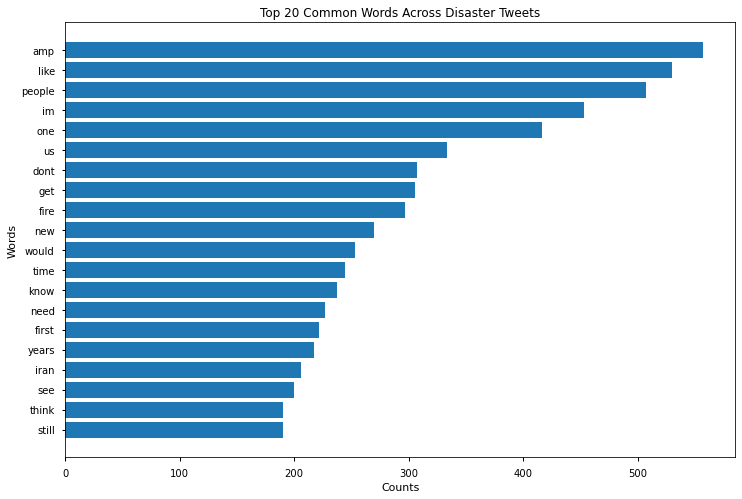

In [21]:
# Plot the top 20 words with their frequencies.
plt.style.use('seaborn-notebook')
plt.figure(figsize=[12,8])
plt.barh(top_words, top_words_frequency)
plt.title("Top 20 Common Words Across Disaster Tweets")
plt.xlabel("Counts")
plt.ylabel("Words")

In [22]:
# Create a list of tweet word counts.
tweet_lengths=[]

for i in range(len(mylist_tokenized_sw)):
    length = len(mylist_tokenized_sw[i])
    tweet_lengths.append(length)

Text(0, 0.5, 'Counts')

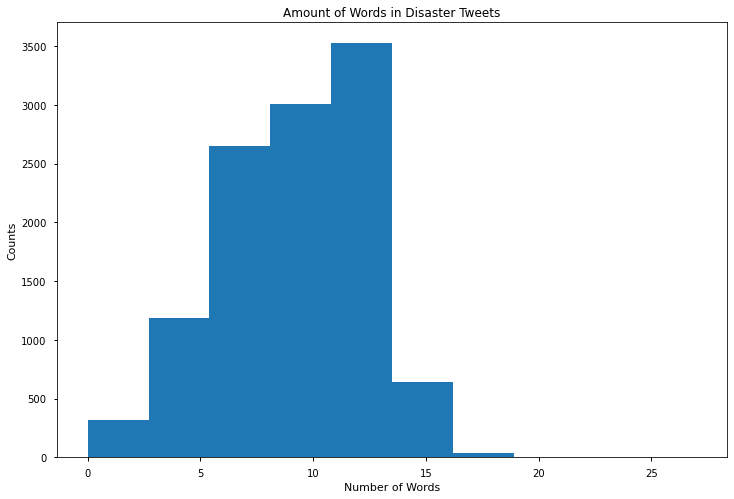

In [23]:
# Plot a histogram of tweet word counts.
plt.figure(figsize=[12,8])
plt.hist(tweet_lengths)
plt.title("Amount of Words in Disaster Tweets")
plt.xlabel("Number of Words")
plt.ylabel("Counts")

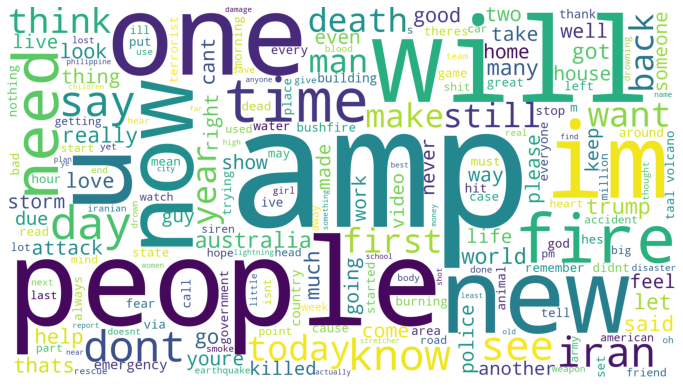

In [24]:
# Plot a word cloud of words across all tweets.
word_cloud_text = " ".join(i for i in mylist)

wordcloud = WordCloud(width = 1800, height = 1000,
                background_color ='white',
                min_font_size = 10).generate(word_cloud_text) # ignores built in stopwords list by default

plt.figure(figsize=[12,12])
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Final Conversions and Saving the Data

In [25]:
# Convert tokens back to sentences for modeling (list of lists --> list)
mylist_tokenized_sw[:1]

cleaned_tweets_final=[]

for tweet in range(len(mylist_tokenized_sw)):
    sentance = " ".join(mylist_tokenized_sw[tweet])
    cleaned_tweets_final.append(sentance)

In [26]:
# Check new list to make sure it looks right.
cleaned_tweets_final[:5]

['communal violence bhainsa telangana stones pelted muslims houses houses vehicles set',
 'telangana section imposed bhainsa january clash erupted two groups january',
 'arsonist sets cars ablaze dealership',
 'arsonist sets cars ablaze dealership',
 'lord jesus love brings freedom pardon fill holy spirit set heart ablaze']

In [27]:
# Check new list's size to make sure all tweets a accounted for.
len(cleaned_tweets_final)

11370

In [28]:
# Create a copy of the tweets dataframe and assign the new list to a new column of our new dataframe and drop the old text column.
cleaned_tweets_df = tweets.copy()
cleaned_tweets_df['text_cleaned'] = cleaned_tweets_final
cleaned_tweets_df.drop(columns='text')

,id,keyword,location,target,text_cleaned
0,0,ablaze,NaN,1,communal violence bhainsa telangana stones pel...
1,1,ablaze,NaN,1,telangana section imposed bhainsa january clas...
2,2,ablaze,New York City,1,arsonist sets cars ablaze dealership
3,3,ablaze,"Morgantown, WV",1,arsonist sets cars ablaze dealership
4,4,ablaze,NaN,0,lord jesus love brings freedom pardon fill hol...
...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,0,media warned us well advance wrecked whole nig...
11366,11366,wrecked,arohaonces,0,feel directly attacked consider moonbin amp ji...
11367,11367,wrecked,🇵🇭,0,feel directly attacked consider moonbin amp ji...
11368,11368,wrecked,auroraborealis,0,ok remember outcast nd dora au au wrecked nerv...


In [29]:
# Save the updated dataframe.
cleaned_tweets_df.to_csv('C:/Users/justi/SpringboardDS/Capstone III/data/cleaned_tweets.csv')